# Prolific Study Evaluation
This notebook loads and processes the raw data collected on Supabase from the online human study done via Prolific.
It reconstructs participant-level and trial-level responses from the stored jsPsych logs,
and prepares clean analysis tables for downstream statistical evaluation.

In [1]:
import os
from dotenv import load_dotenv
from supabase import create_client
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from PIL import Image
from scipy import stats
import numpy as np

load_dotenv()

SUPABASE_URL = "https://utwhgfveotpusdjopcnl.supabase.co"
SUPABASE_KEY = os.environ["SUPABASE_SERVICE_ROLE"]

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)

# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

In [2]:
# Read out results table and print as dataframe
response = supabase.table("results").select("*").execute()

rows = response.data
df_raw = pd.DataFrame(rows)

# Drop all test and debug participants
df_raw = df_raw[(~df_raw['prolific_pid'].str.startswith('DEBUG')) &
    (~df_raw['prolific_pid'].str.startswith('TEST_'))
].copy()

cutoff = pd.Timestamp("2026-02-03 11:10:55.661533+00", tz="UTC")
df_raw = df_raw[pd.to_datetime(df_raw["created_at"], utc=True) >= cutoff]

display(df_raw)
print(df_raw.shape)

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
24,67c36565-ecf2-4655-a5f6-d3e86b19dcc6,5dd2ccf12e6c772de06f525b,profile_23_last,completed,2026-02-03T11:13:06.096269+00:00,"[{'rt': 1722, 'study_id': '6962232f30c21461e6a...",1770117186247,1770116663290,31
25,cc408b35-1a37-439d-8e76-11ba7a596404,697a5d3fb0c089ca2e54958a,profile_33_first,completed,2026-02-03T11:13:13.411361+00:00,"[{'rt': 23496, 'study_id': '6962232f30c21461e6...",1770117192502,1770116696579,52
26,53f4d379-699c-4a1b-9fdf-e177887c638f,5f3adfbf2e598b7a0b73c45e,profile_20_last,completed,2026-02-03T11:13:19.079171+00:00,"[{'rt': 5852, 'study_id': '6962232f30c21461e6a...",1770117197118,1770116662731,25
46,d39b2495-ab78-47d9-8ab6-55f7ac40ca2b,5e3ddcf95556b204cb143eab,profile_29_last,completed,2026-02-03T11:13:27.843382+00:00,"[{'rt': 15900, 'study_id': '6962232f30c21461e6...",1770117207663,1770116680483,43
47,7fa24d31-ea02-4cd4-8b82-5afbfeb09072,6658b32dd8c3da854c842802,profile_14_last,completed,2026-02-03T11:13:37.649977+00:00,"[{'rt': 5467, 'study_id': '6962232f30c21461e6a...",1770117216893,1770116783947,11
...,...,...,...,...,...,...,...,...,...
240,2702223e-cd3a-48f4-b783-a9ccad6902a7,696abe3b7d7f518c6540fa45,profile_35_first,completed,2026-02-07T14:52:11.717503+00:00,"[{'rt': 20172, 'study_id': '6980c852b1ec006643...",1770475930203,1770475194488,35
241,80a3704a-8168-440b-9d78-7bde71e801fa,604db6324496c57afe822770,profile_18_last,completed,2026-02-07T14:54:16.791672+00:00,"[{'rt': 8493, 'study_id': '6980c852b1ec006643f...",1770476056092,1770475102273,20
242,d6a5cde0-922f-4d55-866a-7d6dd3249c0d,665ee374604d2c5d4d858efd,profile_32_first,completed,2026-02-07T14:57:42.397018+00:00,"[{'rt': 8443, 'study_id': '6980c852b1ec006643f...",1770476261089,1770475460953,45
243,b48ecd00-c2c4-423c-ab8a-57e4a041b14e,5e8b9c7054a5cc07dd6e174d,profile_33_last,completed,2026-02-07T15:11:34.542454+00:00,"[{'rt': 12669, 'study_id': '6980c852b1ec006643...",1770477094161,1770476477662,46


(161, 9)


In [3]:
# Dataframe from 10 prolific test participants, only one "certainty" trial per participant and wrong response time tracking
df_prolific_test = pd.DataFrame(rows)

# Drop all test and debug participants
df_prolific_test = df_prolific_test[(~df_prolific_test['prolific_pid'].str.startswith('DEBUG')) &
    (~df_prolific_test['prolific_pid'].str.startswith('TEST_'))
].copy()

start_cutoff = pd.Timestamp("2026-01-28 12:50:00+00:00", tz="UTC")
main_cutoff  = pd.Timestamp("2026-02-02 11:10:55.661533+00", tz="UTC")

df_prolific_test["created_at"] = pd.to_datetime(df_prolific_test["created_at"], utc=True)

df_prolific_test = df_prolific_test[
    (df_prolific_test["created_at"] >= start_cutoff)
    & (df_prolific_test["created_at"] <  main_cutoff)
]


display(df_prolific_test)
print(df_prolific_test.shape)

profiles_raw = set(df_raw["profile_id"].dropna().astype(str))
profiles_extra = set(df_prolific_test["profile_id"].dropna().astype(str))

overlap = profiles_raw & profiles_extra

print("Profiles in df_raw:", len(profiles_raw))
print("Profiles in df_prolific_test:", len(profiles_extra))
print("Overlapping profiles:", len(overlap))

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
73,9c0d06ee-31ab-4c79-9f29-60340eb12bc2,5997043dbbe84800017964a7,profile_6_last,failed_distractor,2026-01-28 12:57:10.075912+00:00,"[{'rt': 11700, 'study_id': '6962232f30c21461e6...",1769605029862,1769604712731,67
74,cae0bb77-d57a-41ca-8dd0-f86f78a6d8da,5a381de00006450001bf2691,profile_17_last,completed,2026-01-28 13:01:09.976787+00:00,"[{'rt': 14626, 'study_id': '6962232f30c21461e6...",1769605269189,1769604706487,17
75,5234326d-6ea1-49fb-93af-ee75e3984bec,676061b0d6e01e2e9548a4b9,profile_23_last,completed,2026-01-28 13:01:43.657952+00:00,"[{'rt': 21763, 'study_id': '6962232f30c21461e6...",1769605302694,1769604839827,31
76,da575643-83eb-4e38-80ce-03c10cd672cd,5bf8a27021a4e1000194fc76,profile_2_last,completed,2026-01-28 13:06:27.084044+00:00,"[{'rt': 14676, 'study_id': '6962232f30c21461e6...",1769605586286,1769605024569,45
77,22802372-74d0-411e-b879-ad9fdd2cf510,6146548679f86b7cb069e7f7,profile_11_last,completed,2026-01-28 13:07:56.910077+00:00,"[{'rt': 17468, 'study_id': '6962232f30c21461e6...",1769605676363,1769604826317,5
78,8d8195d4-b457-4dc8-8759-55a0fd0bdd29,5c5cad3e4ee81200018eafe2,profile_33_last,completed,2026-01-28 13:08:39.759393+00:00,"[{'rt': 12588, 'study_id': '6962232f30c21461e6...",1769605719886,1769604862872,53
79,1a28d289-0ebb-4d80-8695-5706704a0021,6053e01a6a8e8516ba7d47a7,profile_3_first,completed,2026-01-28 13:11:20.176687+00:00,"[{'rt': 17185, 'study_id': '6962232f30c21461e6...",1769605879714,1769604911837,60
80,af0da243-8692-4325-8db2-4342e07029c7,571bdaa76b0894001362f780,profile_7_first,completed,2026-01-28 13:15:48.124049+00:00,"[{'rt': 1575, 'study_id': '6962232f30c21461e6a...",1769606146541,1769605546811,68
81,6950a956-3a7a-4d54-ada1-1895374aa902,676063838d4db0d3eaa69c2b,profile_13_last,completed,2026-01-28 13:17:42.084933+00:00,"[{'rt': 1414, 'study_id': '6962232f30c21461e6a...",1769606181795,1769605539794,9
82,7c24ad90-a9d6-44d4-80d1-ea16478e0096,61517db6a7589569521b2356,profile_35_first,failed_attention,2026-01-28 13:24:27.069578+00:00,"[{'rt': 28624, 'study_id': '6962232f30c21461e6...",1769606665652,1769605461409,56


(12, 9)
Profiles in df_raw: 69
Profiles in df_prolific_test: 12
Overlapping profiles: 12


In [4]:
# Missing profiles from the main prolific run are filled up by 5 volunteers
df_volunteers = pd.DataFrame(rows)

# Drop all test and debug participants
df_volunteers = df_volunteers[(~df_volunteers['prolific_pid'].str.startswith('DEBUG')) &
    (df_volunteers['prolific_pid'].str.startswith('TEST_'))
].copy()

start_cutoff = pd.Timestamp("2026-02-08 07:43:32.570752+00", tz="UTC")
main_cutoff  = pd.Timestamp("2026-02-11 22:05:22.34968+00", tz="UTC")

df_volunteers["created_at"] = pd.to_datetime(df_volunteers["created_at"], utc=True)

df_volunteers = df_volunteers[
    (df_volunteers["created_at"] >= start_cutoff)
    & (df_volunteers["created_at"] <=  main_cutoff)
]

df_volunteers["created_at"] = pd.to_datetime(df_volunteers["created_at"], utc=True)

df_volunteers = df_volunteers[
    (df_volunteers["created_at"] >= cutoff)
]

display(df_volunteers)
print(df_volunteers.shape)

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
245,6d93eb19-303f-4090-9445-6a36d5491cbe,TEST_ba6227fa-c0b3-45ba-9f11-848acec6aa28,profile_9_last,completed,2026-02-08 07:43:32.570752+00:00,"[{'rt': 31143, 'exit_time': 1770536611298, 'ti...",1770536611298,1770535783798,61
246,0a7b287c-14ab-4421-8126-468965d1d8c2,TEST_6fde0f1f-6fd3-4f1e-8910-6f0f4f74fd32,profile_15_last,completed,2026-02-08 09:03:30.270853+00:00,"[{'rt': 35452, 'exit_time': 1770541408185, 'ti...",1770541408185,1770540674588,69
247,bb19c1ed-7bfa-4fc4-9a37-3ad38c62ddcc,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,completed,2026-02-09 13:11:27.427048+00:00,"[{'rt': 2363, 'exit_time': 1770642685031, 'tim...",1770642685031,1770636313656,70
248,7cb39df0-7535-406f-98dc-2a2bf482d77a,TEST_1,profile_36_last,failed_distractor,2026-02-09 13:12:25.077182+00:00,"[{'rt': 1641, 'exit_time': 1770642744653, 'pro...",1770642744653,1770642730588,2
249,344e7442-344f-4e2f-ad49-5a616e254264,TEST_fe9bf5a0-a286-4fd7-9277-3c3a769f8108,profile_36_last,failed_attention,2026-02-10 14:45:15.544133+00:00,"[{'rt': 2338, 'exit_time': 1770734713917, 'tim...",1770734713917,1770734252712,2
250,9b4e7b50-b3ce-4fea-bdbc-d4a239d3fbe4,TEST_dfadd2b8-6972-445d-b2ba-c0e58d75d5a8,profile_36_last,completed,2026-02-11 15:36:24.178034+00:00,"[{'rt': 26643, 'exit_time': 1770824182580, 'ti...",1770824182580,1770823420052,2
251,ec6d0668-e51b-4e0e-bd38-e83d829bd1fb,TEST_77ef0348-c4de-435f-ab81-95737f112ff1,profile_25_last,failed_distractor,2026-02-11 16:02:49.200195+00:00,"[{'rt': 80013, 'exit_time': 1770825767264, 'ti...",1770825767264,1770825177517,13
252,c7528e07-4a77-401e-996b-f1ed6a9c5d7d,TEST_8b185b98-7823-4f8f-a50d-cb24aaee8b67,profile_25_last,completed,2026-02-11 22:05:22.349680+00:00,"[{'rt': 9761, 'exit_time': 1770847520331, 'tim...",1770847520331,1770846314194,13


(8, 9)


In [5]:
# Combine the two dataframes extra dfs with the main study to get the complete dataset for evaluation
df_extra = pd.concat([df_prolific_test, df_volunteers], ignore_index=True)
df_raw = pd.concat([df_raw, df_extra], ignore_index=True)
display(df_raw)

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
0,67c36565-ecf2-4655-a5f6-d3e86b19dcc6,5dd2ccf12e6c772de06f525b,profile_23_last,completed,2026-02-03T11:13:06.096269+00:00,"[{'rt': 1722, 'study_id': '6962232f30c21461e6a...",1770117186247,1770116663290,31
1,cc408b35-1a37-439d-8e76-11ba7a596404,697a5d3fb0c089ca2e54958a,profile_33_first,completed,2026-02-03T11:13:13.411361+00:00,"[{'rt': 23496, 'study_id': '6962232f30c21461e6...",1770117192502,1770116696579,52
2,53f4d379-699c-4a1b-9fdf-e177887c638f,5f3adfbf2e598b7a0b73c45e,profile_20_last,completed,2026-02-03T11:13:19.079171+00:00,"[{'rt': 5852, 'study_id': '6962232f30c21461e6a...",1770117197118,1770116662731,25
3,d39b2495-ab78-47d9-8ab6-55f7ac40ca2b,5e3ddcf95556b204cb143eab,profile_29_last,completed,2026-02-03T11:13:27.843382+00:00,"[{'rt': 15900, 'study_id': '6962232f30c21461e6...",1770117207663,1770116680483,43
4,7fa24d31-ea02-4cd4-8b82-5afbfeb09072,6658b32dd8c3da854c842802,profile_14_last,completed,2026-02-03T11:13:37.649977+00:00,"[{'rt': 5467, 'study_id': '6962232f30c21461e6a...",1770117216893,1770116783947,11
...,...,...,...,...,...,...,...,...,...
176,7cb39df0-7535-406f-98dc-2a2bf482d77a,TEST_1,profile_36_last,failed_distractor,2026-02-09 13:12:25.077182+00:00,"[{'rt': 1641, 'exit_time': 1770642744653, 'pro...",1770642744653,1770642730588,2
177,344e7442-344f-4e2f-ad49-5a616e254264,TEST_fe9bf5a0-a286-4fd7-9277-3c3a769f8108,profile_36_last,failed_attention,2026-02-10 14:45:15.544133+00:00,"[{'rt': 2338, 'exit_time': 1770734713917, 'tim...",1770734713917,1770734252712,2
178,9b4e7b50-b3ce-4fea-bdbc-d4a239d3fbe4,TEST_dfadd2b8-6972-445d-b2ba-c0e58d75d5a8,profile_36_last,completed,2026-02-11 15:36:24.178034+00:00,"[{'rt': 26643, 'exit_time': 1770824182580, 'ti...",1770824182580,1770823420052,2
179,ec6d0668-e51b-4e0e-bd38-e83d829bd1fb,TEST_77ef0348-c4de-435f-ab81-95737f112ff1,profile_25_last,failed_distractor,2026-02-11 16:02:49.200195+00:00,"[{'rt': 80013, 'exit_time': 1770825767264, 'ti...",1770825767264,1770825177517,13


In [10]:
# Find out if any profiles are missing
resp = (
        supabase
        .table("profile_assignments")
        .select("*")
        .eq("completed", False)
        .limit(1)
        .execute()
    )

df_profiles = pd.DataFrame(resp.data)

remaining = df_profiles[df_profiles["completed"] == False]

print("Remaining profiles:", len(remaining))
display(remaining.sort_values("profile_id"))


Remaining profiles: 1


,profile_id,profile_index,assigned_to,assigned_at,completed
0,profile_2_first,70,None,None,False


profile_id
profile_23_last     6
profile_20_last     5
profile_34_last     5
profile_28_first    5
profile_7_first     5
                   ..
profile_9_last      1
profile_15_last     1
profile_2_first     1
profile_36_last     1
profile_25_last     1
Name: count, Length: 74, dtype: int64


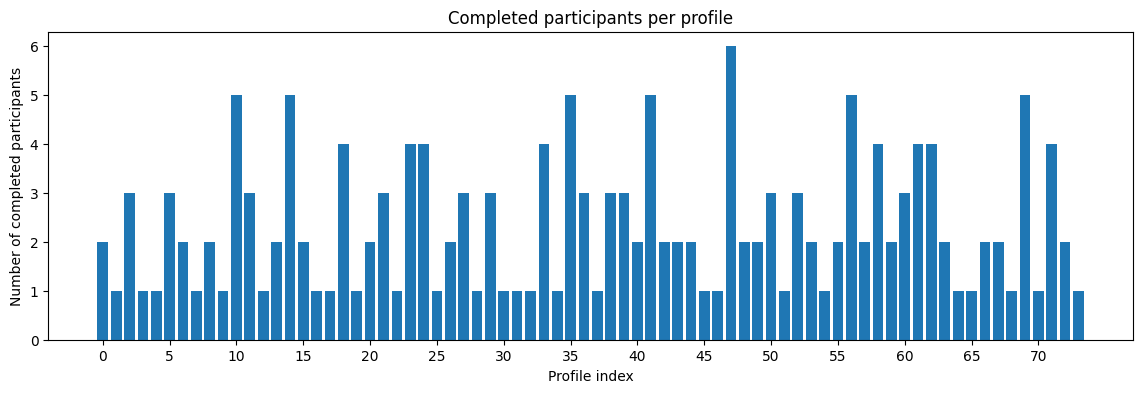

In [160]:
N_PROFILES = 37
intro_positions = ["first", "last"]

all_profiles = [
    f"profile_{i}_{pos}"
    for i in range(N_PROFILES)
    for pos in intro_positions
]

completed = df_raw[df_raw["exit_reason"] == "completed"]

profile_counts = (
    completed["profile_id"]
    .value_counts()
    .reindex(all_profiles, fill_value=0)
)
print(df_raw[df_raw["exit_reason"] == "completed"]["profile_id"].value_counts())

fig, ax = plt.subplots(figsize=(14, 4))

ax.bar(range(len(profile_counts)), profile_counts.values)

ax.set_xlabel("Profile index")
ax.set_ylabel("Number of completed participants")
ax.set_title("Completed participants per profile")

step = 5  # show every 5th profile
ax.set_xticks(range(0, len(profile_counts), step))
ax.set_xticklabels(range(0, len(profile_counts), step))

plt.show()


In [164]:
profile_counts[profile_counts == 0]

Series([], Name: count, dtype: int64)

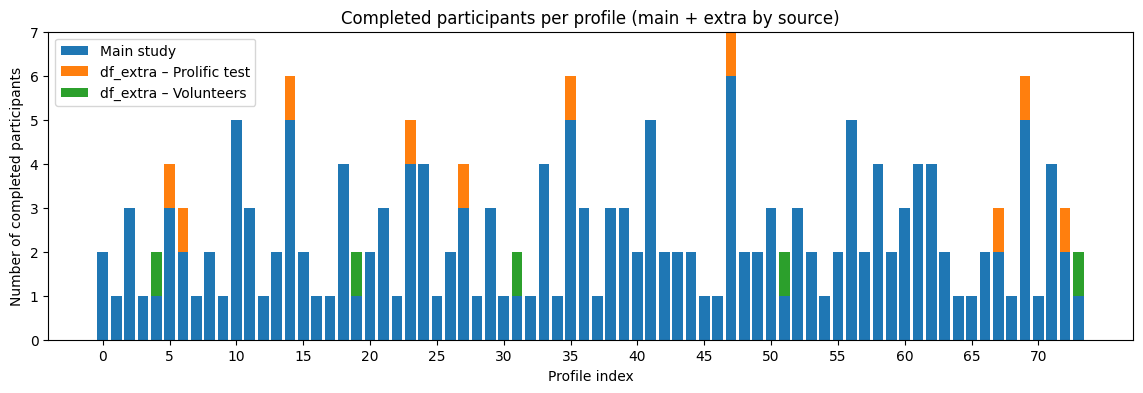

In [165]:
N_PROFILES = 37
intro_positions = ["first", "last"]

all_profiles = [
    f"profile_{i}_{pos}"
    for i in range(N_PROFILES)
    for pos in intro_positions
]

# main study
completed_raw = df_raw[df_raw["exit_reason"] == "completed"]

profile_counts_raw = (
    completed_raw["profile_id"]
    .value_counts()
    .reindex(all_profiles, fill_value=0)
)

# extra
# df_extra successful completions only
completed_extra = df_extra[df_extra["exit_reason"] == "completed"]

# volunteers
completed_extra_volunteers = completed_extra[
    completed_extra["prolific_pid"].str.startswith("TEST_")
]

# prolific test run
completed_extra_prolific = completed_extra[
    ~completed_extra["prolific_pid"].str.startswith("TEST_")
]

profile_counts_extra_volunteers = (
    completed_extra_volunteers["profile_id"]
    .value_counts()
    .reindex(all_profiles, fill_value=0)
)

profile_counts_extra_prolific = (
    completed_extra_prolific["profile_id"]
    .value_counts()
    .reindex(all_profiles, fill_value=0)
)

fig, ax = plt.subplots(figsize=(14, 4))

x = range(len(all_profiles))

# base: main study
ax.bar(
    x,
    profile_counts_raw.values,
    label="Main study",
)

# middle: df_extra (Prolific test)
ax.bar(
    x,
    profile_counts_extra_prolific.values,
    bottom=profile_counts_raw.values,
    label="df_extra – Prolific test",
    color="tab:orange",
)

# top: df_extra (volunteers)
ax.bar(
    x,
    profile_counts_extra_volunteers.values,
    bottom=profile_counts_raw.values + profile_counts_extra_prolific.values,
    label="df_extra – Volunteers",
    color="tab:green",
)

ax.set_xlabel("Profile index")
ax.set_ylabel("Number of completed participants")
ax.set_title("Completed participants per profile (main + extra by source)")

step = 5
ax.set_xticks(range(0, len(all_profiles), step))
ax.set_xticklabels(range(0, len(all_profiles), step))

ax.legend()
plt.show()

In [166]:
# Explode df_raw into trial-level df 
rows = []

for _, row in df_raw.iterrows():
    pid = row["prolific_pid"]
    profile_id = row["profile_id"]
    exit_reason = row["exit_reason"]

    if profile_id.endswith("_first"):
        intro_position = "first"
    elif profile_id.endswith("_last"):
        intro_position = "last"
    else:
        intro_position = None

    for trial in row["data"]:
        flat = {
            "PROLIFIC_PID": pid,
            "profile_id": profile_id,
            "exit_reason": exit_reason,
            "intro_position": intro_position,
        }
        flat.update(trial)
        rows.append(flat)

df = pd.DataFrame(rows)
df = df.dropna(axis=1, how="all")

display(df.head(10))
print("Shape:", df.shape)


,PROLIFIC_PID,profile_id,exit_reason,intro_position,rt,study_id,exit_time,timed_out,session_id,subject_id,...,certainty_change_count,passed,response,sanity_id,question_order,response_index,correct_response,stimulus,slider_start,certainty
0,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,1722.0,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,16150.0,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,NaN,True,{'Q0': 4},1.0,[0],4.0,Strongly Disagree,NaN,NaN,NaN
6,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5dd2ccf12e6c772de06f525b,profile_23_last,completed,last,NaN,6962232f30c21461e6a14157,1770117186247,True,6981d62c8fcaa26b61c71e64,5dd2ccf12e6c772de06f525b,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (18952, 44)


In [121]:
#df_raw.to_csv(DATA / "prolific_stimuli" / "prolific_results_by_profile.csv", index=False)
#df.to_csv(DATA / "prolific_stimuli" / "prolific_results_by_trial.csv", index=False)

In [172]:
print("Task type counts:")
print(df["task_type"].value_counts())
print("\nExit reason counts:")
print(df_raw["exit_reason"].value_counts(dropna=False))

Task type counts:
task_type
color_judgment    17668
sanity              887
introspection       176
warning              40
Name: count, dtype: int64

Exit reason counts:
exit_reason
completed            172
failed_distractor      7
failed_attention       2
Name: count, dtype: int64


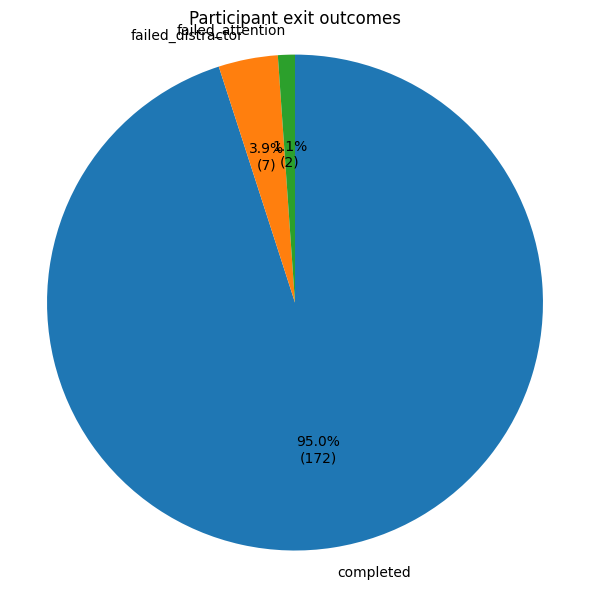

In [173]:
# Dropouts vs completions
exit_counts = df_raw['exit_reason'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    exit_counts,
    labels=exit_counts.index,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p/100 * exit_counts.sum()))})",
    startangle=90,
    counterclock=False,
)
plt.title("Participant exit outcomes")
plt.axis("equal")
plt.tight_layout()
plt.show()

## Failed by distractor colors

Number of failed trials: 12


,PROLIFIC_PID,object,variant_region,percent_colored,target_color,response_label,image_path
969,5e0f26b63ccda26295505f0d,rooster,FG,0.0,white,blue,color_images/gpt-4o/image_priors/rooster_3_c62...
1030,5e0f26b63ccda26295505f0d,square,FG,55.0,brown,blue,shapes/shape_colored/square_v1_brown/FG_055_se...
5892,6784133089e3f78e0e08c94d,hexagon,FG,60.0,purple,yellow,shapes/shape_colored/hexagon_v0_purple/FG_060_...
5900,6784133089e3f78e0e08c94d,beets,BG,40.0,white,red,color_images/gpt-4o/image_priors/beets_2_c2d24...
14621,677743bf62e157794cf97ff4,square,FG,50.0,grey,red,shapes/shape_colored/square_v0_grey/FG_050_seq...
14625,677743bf62e157794cf97ff4,celery,FG,40.0,brown,blue,color_images/gpt-4o/counterfact/celery_4_c500b...
15216,60673bc6496cefa66a61e737,corn,FG,90.0,green,red,color_images/gpt-4o/image_priors/corn_2_9ff217...
15233,60673bc6496cefa66a61e737,boat,BG,20.0,white,blue,color_images/gpt-4o/image_priors/boat_2_a24f90...
18569,TEST_1,pentagon,FG,40.0,purple,yellow,shapes/shape_colored/pentagon_v0_purple/FG_040...
18571,TEST_1,radio,BG,80.0,white,blue,color_images/gpt-4o/image_priors/radio_3_4d87b...


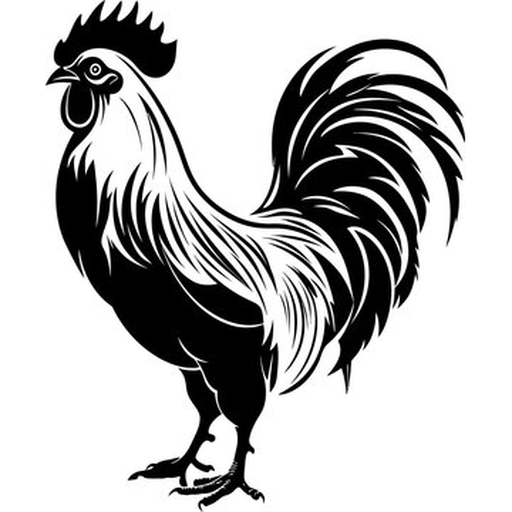

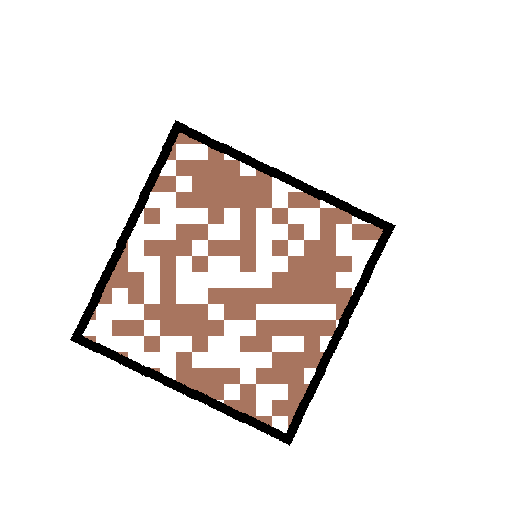

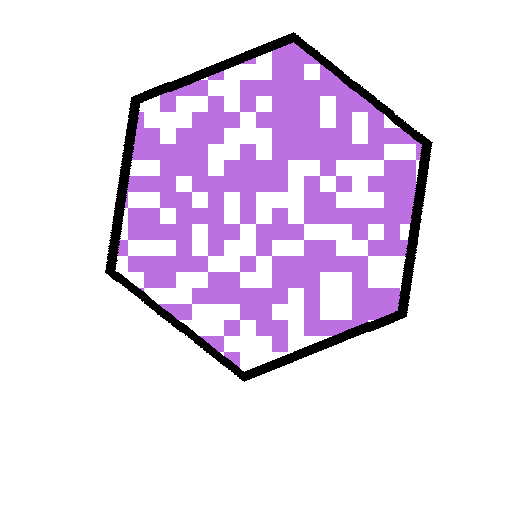

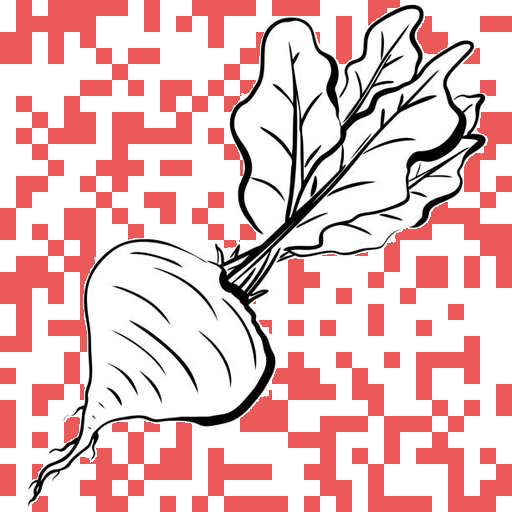

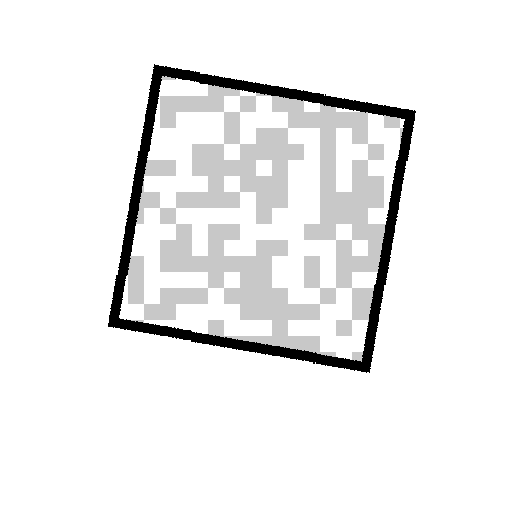

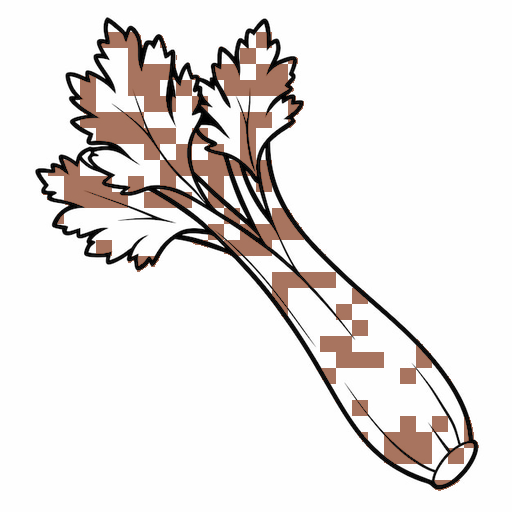

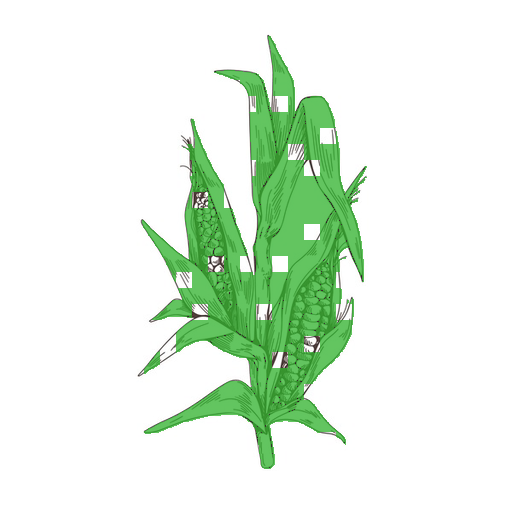

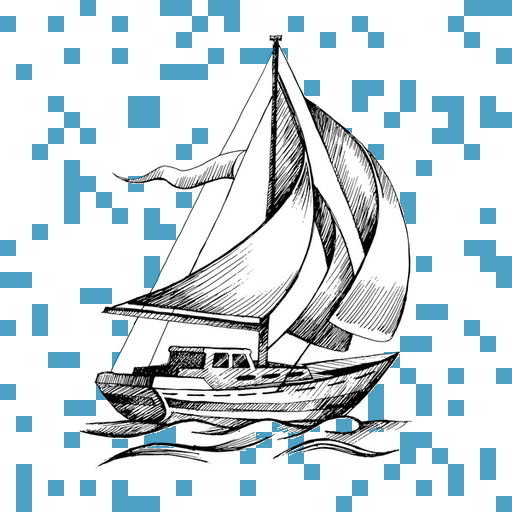

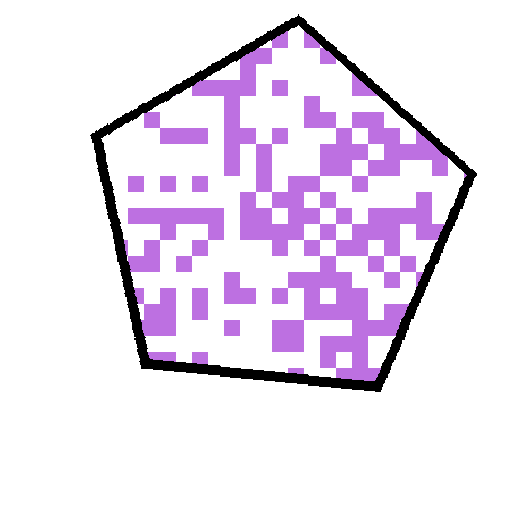

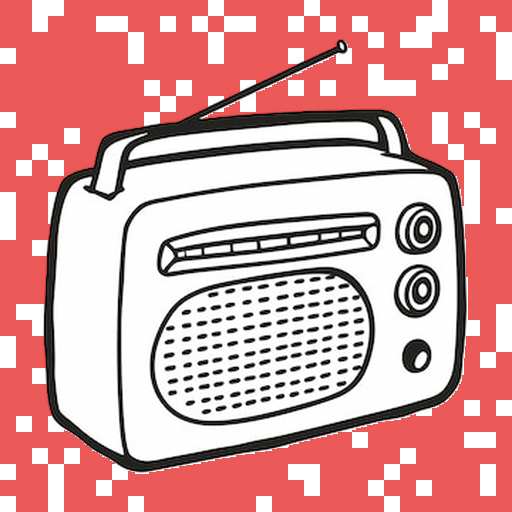

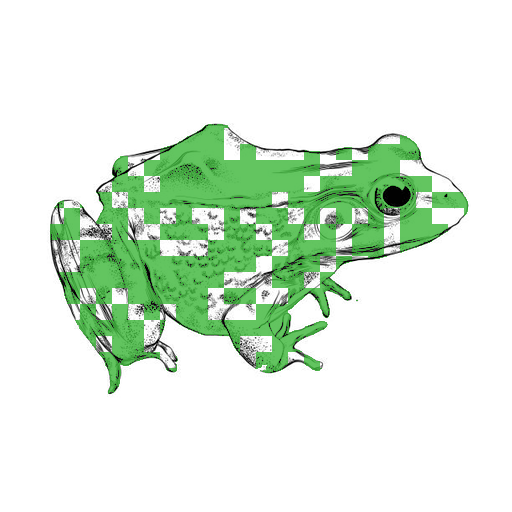

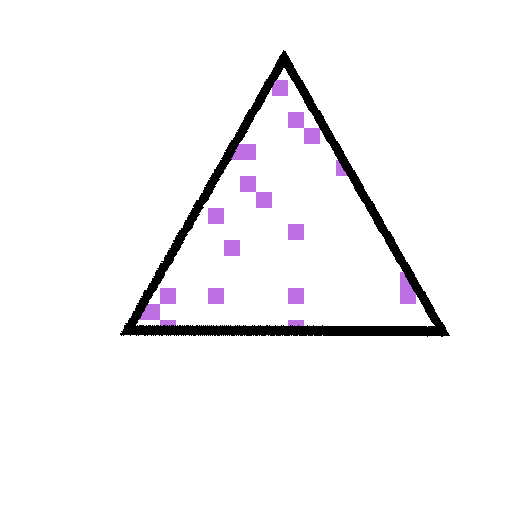

In [174]:
# Inpect failed distractor trials
df_failed = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "failed_distractor") &
    (df["target_color"] != df["response_label"]) &
    (df["response_label"] != "white")
].copy()

print(f"Number of failed trials: {len(df_failed)}")
display(df_failed[[
    "PROLIFIC_PID",
    "object",
    "variant_region",
    "percent_colored",
    "target_color",
    "response_label",
    "image_path"
]])

for _, row in df_failed.iterrows():
    img_path = DATA / Path(row["image_path"])
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        display(img)

## Succesfull completions

In [175]:
# Extract only valid color judgments for analysis)
df_complete = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "completed") 
].copy()

# Drop emtpy columns (those cary information for introspection or attention checks)
before = df_complete.shape[1]
df_complete = df_complete.dropna(axis=1, how="all")
after = df_complete.shape[1]

print(f"Dropped {before - after} empty columns")

len(df_complete)

Dropped 10 empty columns


17200

In [176]:
image_counts = (
    df_complete[df_complete["exit_reason"] == "completed"]
    .groupby(["stimulus_type", "image_path"])
    .size()
    .reset_index(name="n_shown")
)
image_counts.sort_values("n_shown")


,stimulus_type,image_path,n_shown
2993,shape,shapes/shape_colored/triangle_v4_purple/FG_100...,2
2988,shape,shapes/shape_colored/triangle_v4_purple/FG_050...,2
40,correct_prior,color_images/gpt-4o/image_priors/Komodo_dragon...,2
2935,shape,shapes/shape_colored/triangle_v3_purple/FG_060...,2
1212,correct_prior,color_images/gpt-4o/image_priors/waffle_iron_1...,2
...,...,...,...
2280,shape,shapes/shape_colored/pentagon_v1_orange/FG_000...,20
686,correct_prior,color_images/gpt-4o/image_priors/jack-o'-lante...,20
993,correct_prior,color_images/gpt-4o/image_priors/sardine_4_1cf...,20
872,correct_prior,color_images/gpt-4o/image_priors/picket_fence_...,20


Number of warnings (wrong responses): 33


,PROLIFIC_PID,object,variant_region,percent_colored,target_color,response_label,image_path
429,6658b32dd8c3da854c842802,great white shark,FG,0.0,white,blue,color_images/gpt-4o/image_priors/great_white_s...
1146,63f77a5dde1ea03305e119e0,cockroach,FG,55.0,brown,blue,color_images/gpt-4o/image_priors/cockroach_1_0...
1519,5f25e860dd98342ce97e7403,camel,FG,5.0,brown,blue,color_images/gpt-4o/image_priors/camel_1_d4d47...
1865,67680e24c4684ebbc6ec8af3,circle,BG,40.0,white,red,shapes/shape_colored/circle_v0_purple/BG_040_s...
1931,574da26c7f1e770007f42d11,frilled lizard,FG,0.0,white,blue,color_images/gpt-4o/image_priors/frilled_lizar...
3168,6978c580d801e64f18d9e3ab,giraffe,FG,70.0,brown,blue,color_images/gpt-4o/image_priors/giraffe_1_785...
3352,58f669cefb4d7500014af69b,gas pump,FG,10.0,red,green,color_images/gpt-4o/image_priors/gas_pump_5_be...
3808,673f6ffebce20832346325de,keyboard,FG,30.0,brown,blue,color_images/gpt-4o/image_priors/keyboard_(mus...
3931,5bf1c9d332cb3b0001f6f1c3,hexagon,FG,30.0,pink,green,shapes/shape_colored/hexagon_v1_pink/FG_030_se...
4056,62cbfe7dd820cc9d2cd7c87a,gas pump,FG,70.0,red,green,color_images/gpt-4o/image_priors/gas_pump_5_be...


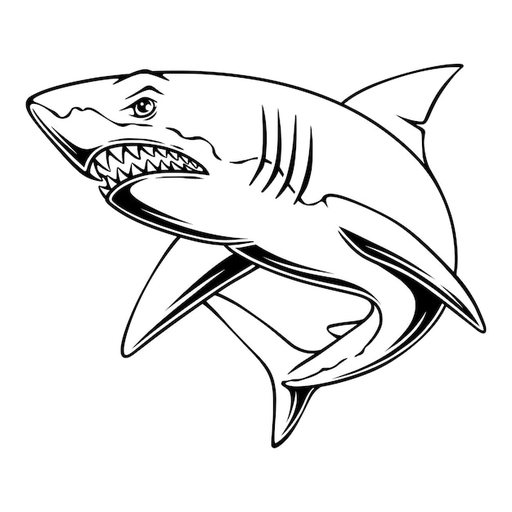

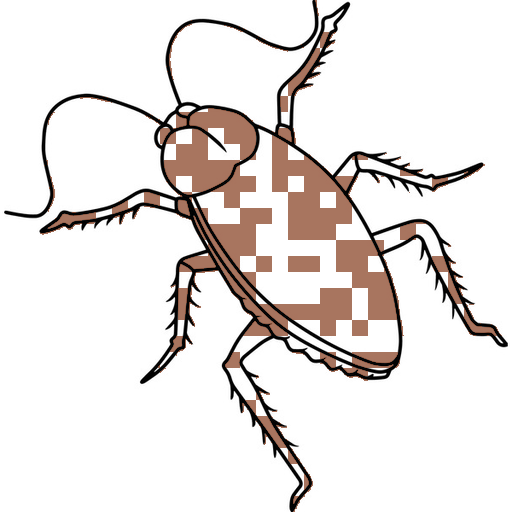

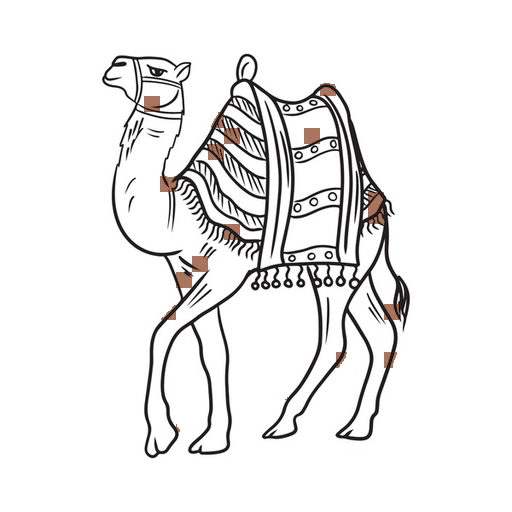

In [202]:
# Warnings
df_warnings = df_complete[(df_complete["target_color"] != df_complete["response_label"]) &
            (df_complete["response_label"] != "white")]

print(f"Number of warnings (wrong responses): {len(df_warnings)}")
display(df_warnings[[
    "PROLIFIC_PID",
    "object",
    "variant_region",
    "percent_colored",
    "target_color",
    "response_label",
    "image_path"
]])

for _, row in df_warnings.head(3).iterrows():
    img_path = DATA / Path(row["image_path"])
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        display(img)

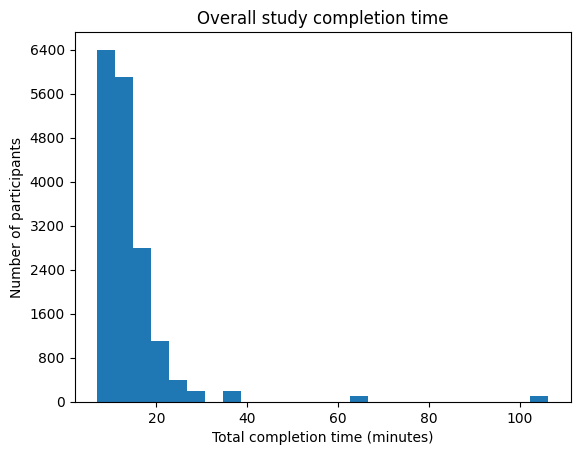

In [178]:
# Participant-level completion time (minutes) 
df_complete['experiment_start_time'] = pd.to_datetime(
    df_complete['experiment_start_time'], unit='ms'
)
df_complete['exit_time'] = pd.to_datetime(
    df_complete['exit_time'], unit='ms'
)

df_complete['total_time_min'] = (
    df_complete['exit_time'] - df_complete['experiment_start_time']
).dt.total_seconds() / 60

# Plot
plt.figure()
plt.hist(df_complete['total_time_min'], bins=25)
plt.xlabel('Total completion time (minutes)')
plt.ylabel('Number of participants')
plt.title('Overall study completion time')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [204]:
df_complete.sort_values("total_time_min", ascending=False)[
    ["PROLIFIC_PID", "profile_id", "total_time_min"]
].head(10)


,PROLIFIC_PID,profile_id,total_time_min
18566,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583
18565,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583
18564,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583
18563,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583
18562,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583
18561,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583
18560,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583
18559,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583
18555,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583
18556,TEST_a6c6492a-1f45-4588-b613-f5c042653d14,profile_2_first,106.189583


### Accuracy vs. coloring fraction

In [179]:
# Accuracy: response must match target_color
df_complete.loc[df_complete["variant_region"] == "BG", "target_color"] = "white" # Fix wrong labels for BG, will be fixed in future study runs
df_complete["accuracy"] = (df_complete["response_label"] == df_complete["target_color"]).astype(float)
df_complete["accuracy"].mean()

np.float64(0.7698837209302326)

In [180]:
grouped = df_complete.groupby(["variant_region", "percent_colored"])

summary = grouped["accuracy"].agg(
    mean="mean",
    std="std",
    n="count"
).reset_index()

# Optional: 95% CI
summary["ci"] = (
    stats.t.ppf(0.975, summary["n"] - 1)
    * (summary["std"] / np.sqrt(summary["n"]))
)


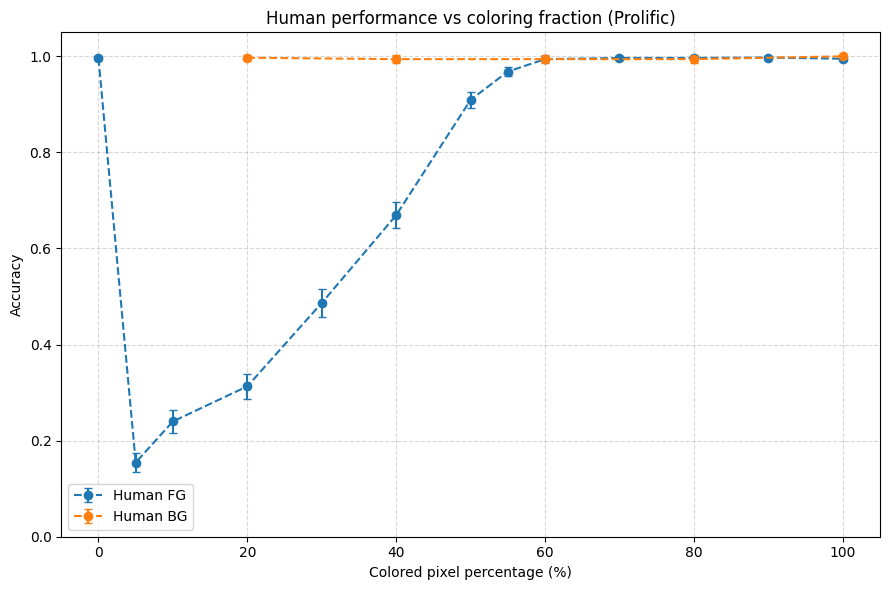

In [181]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

for region in ["FG", "BG"]:
    sub = summary[summary["variant_region"] == region]
    if sub.empty:
        continue

    ax.errorbar(
        sub["percent_colored"],
        sub["mean"],
        yerr=sub["ci"],
        fmt="o--",
        color=colors[region],
        capsize=3,
        label=f"Human {region}",
    )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1.05)
ax.set_title("Human performance vs coloring fraction (Prolific)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


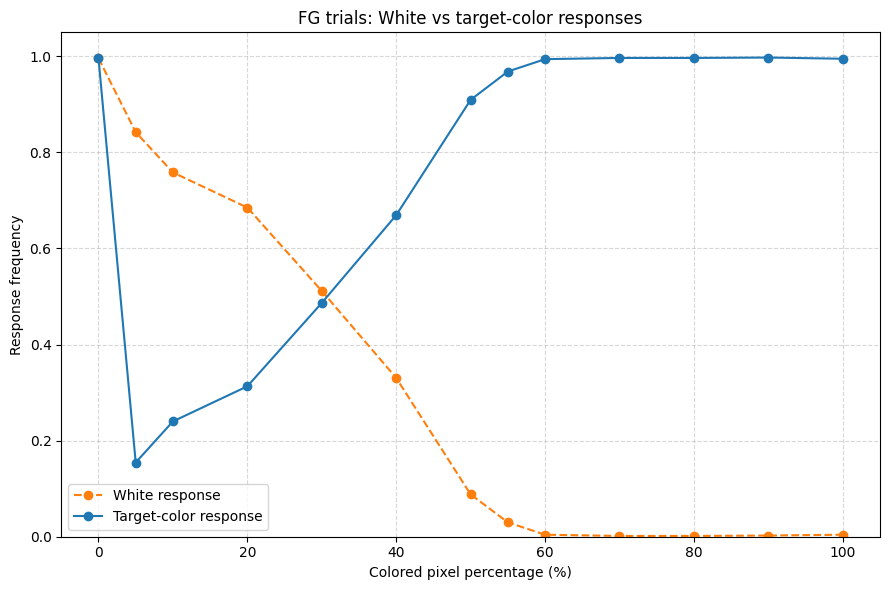

In [182]:
df_fg = df_complete[df_complete["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

fg_summary = (
    df_fg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_target=("is_target", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_white"],
    "o--",
    label="White response",
    color="#ff7f0e",
)

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_target"],
    "o-",
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

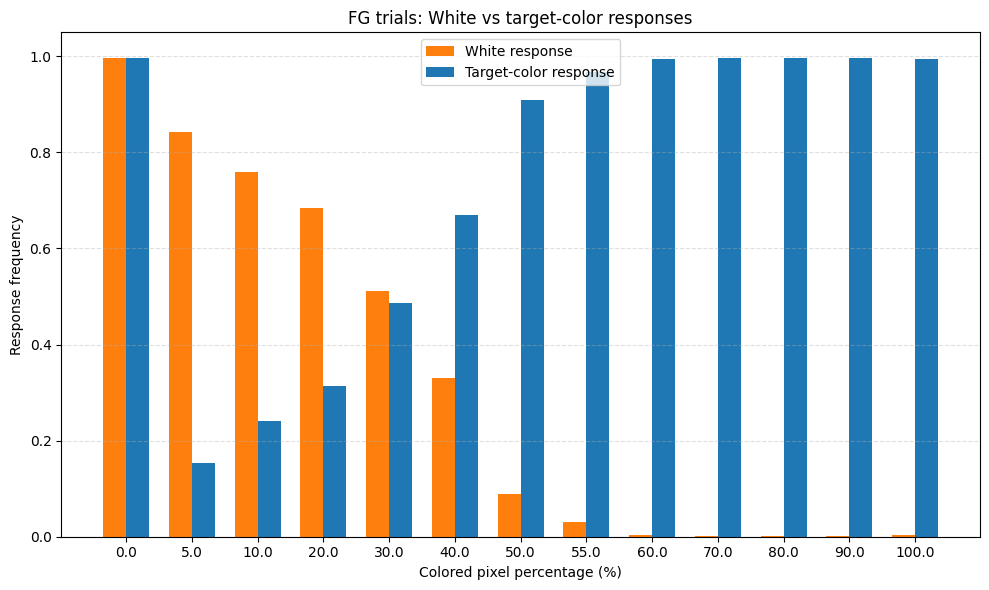

In [183]:
x = np.arange(len(fg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    fg_summary["p_white"],
    width,
    label="White response",
    color="#ff7f0e",
)

ax.bar(
    x + width / 2,
    fg_summary["p_target"],
    width,
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xticks(x)
ax.set_xticklabels(fg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


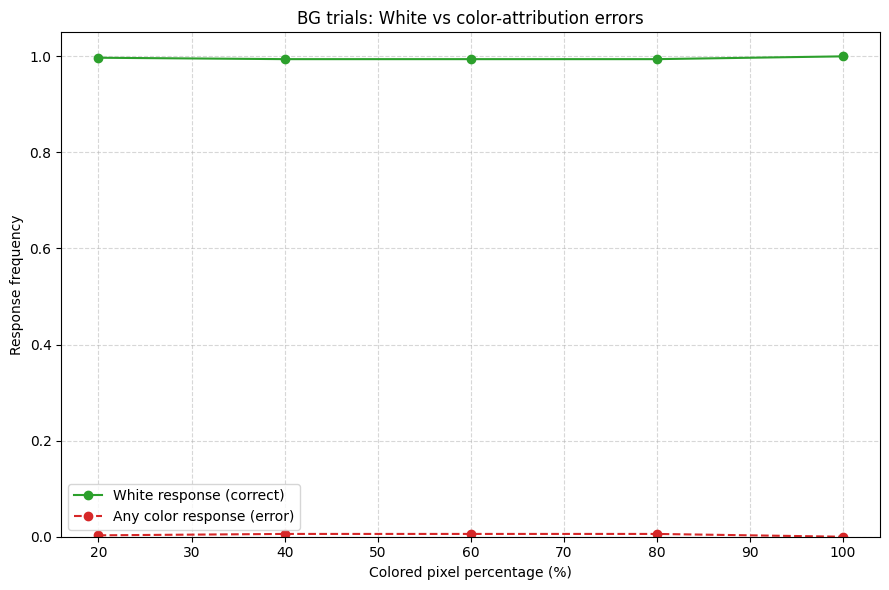

In [184]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

bg_summary = (
    df_bg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_colored=("is_colored", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_white"],
    "o-",
    label="White response (correct)",
    color="#2ca02c",
)

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_colored"],
    "o--",
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

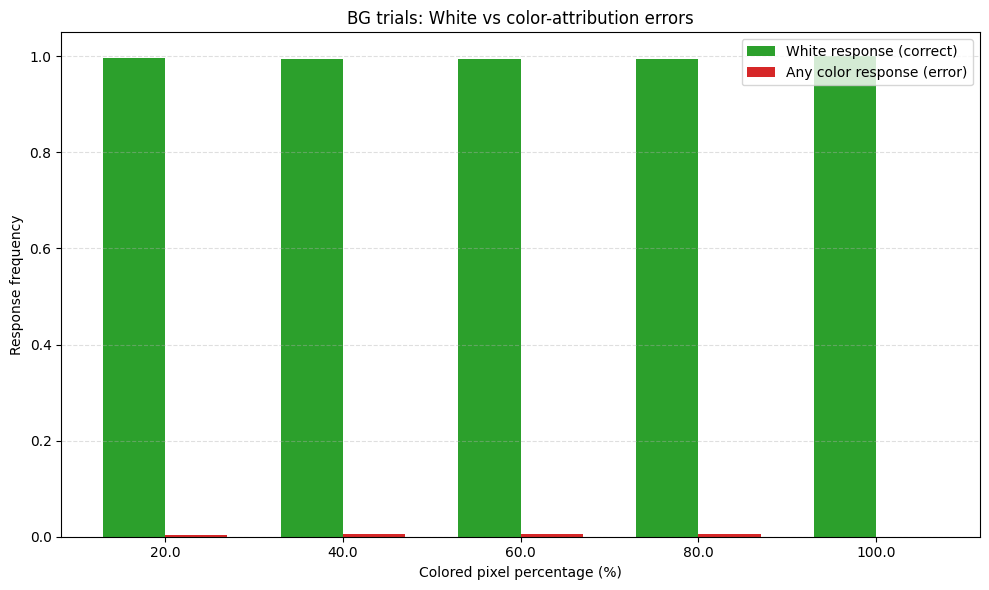

In [185]:
x = np.arange(len(bg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    bg_summary["p_white"],
    width,
    label="White response (correct)",
    color="#2ca02c",
)

ax.bar(
    x + width / 2,
    bg_summary["p_colored"],
    width,
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xticks(x)
ax.set_xticklabels(bg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

### Certainty vs. coloring fraction

In [186]:
df_cert = df_complete.copy()

# Make sure certainty is numeric
df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

# If final is missing, fall back to initial
df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(["variant_region", "percent_colored"])
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

final_summary = summarize_certainty(df_cert, "final_certainty")
initial_summary = summarize_certainty(df_cert, "initial_certainty")

cert_summary = pd.concat([initial_summary, final_summary], ignore_index=True)

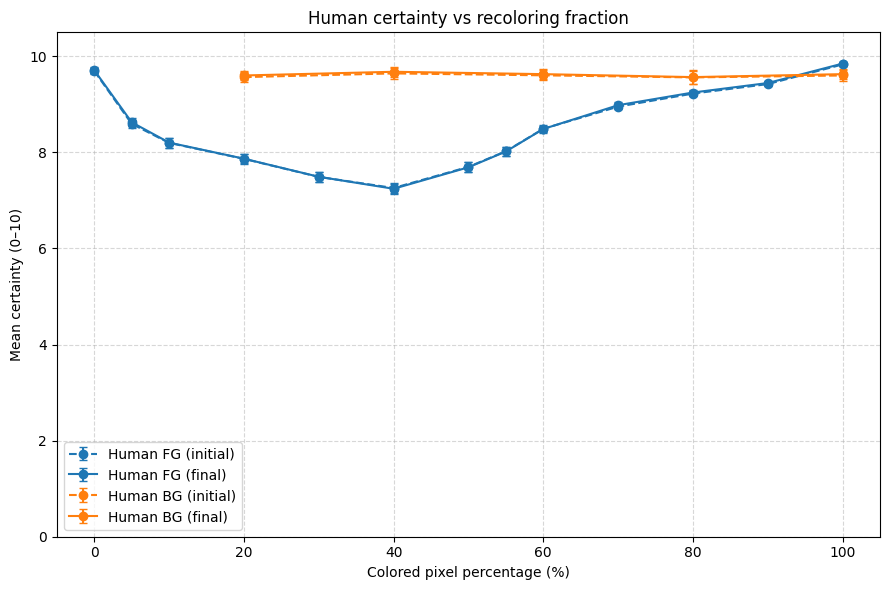

In [187]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

linestyles = {
    "initial_certainty": "--",
    "final_certainty": "-",
}

labels = {
    ("FG", "initial_certainty"): "Human FG (initial)",
    ("FG", "final_certainty"): "Human FG (final)",
    ("BG", "initial_certainty"): "Human BG (initial)",
    ("BG", "final_certainty"): "Human BG (final)",
}

for region in ["FG", "BG"]:
    for cert_type in ["initial_certainty", "final_certainty"]:
        sub = cert_summary[
            (cert_summary["variant_region"] == region) &
            (cert_summary["certainty_type"] == cert_type)
        ]

        if sub.empty:
            continue

        ax.errorbar(
            sub["percent_colored"],
            sub["mean"],
            yerr=sub["ci"],
            fmt="o",
            linestyle=linestyles[cert_type],
            color=colors[region],
            capsize=3,
            label=labels[(region, cert_type)],
        )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Mean certainty (0–10)")
ax.set_ylim(0, 10.5)
ax.set_title("Human certainty vs recoloring fraction")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


## Response times

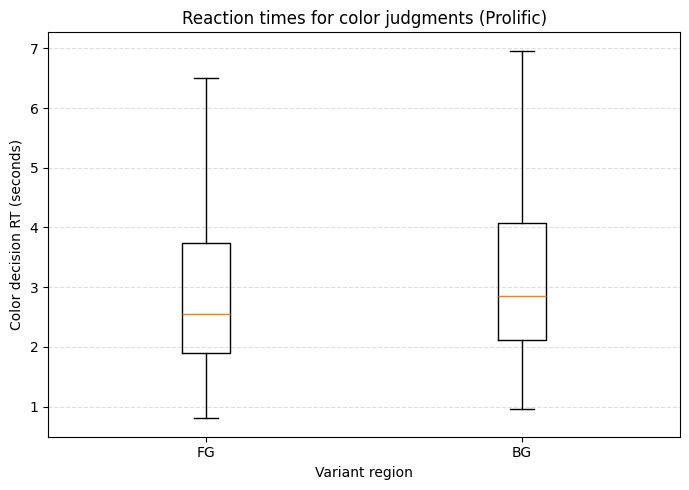

In [188]:
df_rt = df_complete.copy()

# ms → seconds
df_rt["color_time"] = df_rt["color_time"] / 1000

# keep valid RTs only
df_color_rt = df_rt[
    df_rt["color_time"].notna() &
    (df_rt["color_time"] > 0)
]

groups = [
    df_color_rt.loc[df_color_rt["variant_region"] == "FG", "color_time"].values,
    df_color_rt.loc[df_color_rt["variant_region"] == "BG", "color_time"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(
    groups,
    tick_labels=["FG", "BG"],
    showfliers=False,
)

plt.xlabel("Variant region")
plt.ylabel("Color decision RT (seconds)")
plt.title("Reaction times for color judgments (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [189]:
df_rt["final_certainty_time"] = df_rt["second_certainty_time"].fillna(
    df_rt["first_certainty_time"]
)

df_rt["rt_certainty_tot_sec"] = (
    (df_rt["final_certainty_time"] - df_rt["color_time"]) / 1000
)

df_rt = df_rt[
    df_rt["rt_certainty_tot_sec"].notna() &
    (df_rt["rt_certainty_tot_sec"] > 0)
]

df_rt["rt_certainty_revision_sec"] = (
    (df_rt["second_certainty_time"] - df_rt["first_certainty_time"]) / 1000
)

df_revision = df_rt[
    df_rt["rt_certainty_revision_sec"].notna() &
    (df_rt["rt_certainty_revision_sec"] > 0)
]

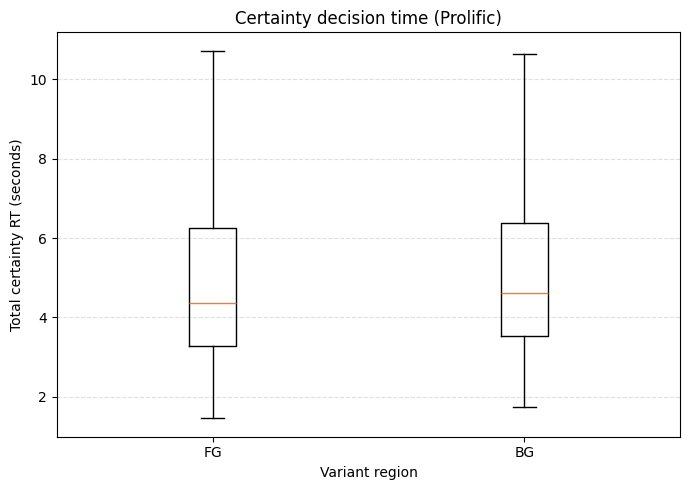

In [190]:
groups = [
    df_rt[df_rt["variant_region"] == "FG"]["rt_certainty_tot_sec"].values,
    df_rt[df_rt["variant_region"] == "BG"]["rt_certainty_tot_sec"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(groups, tick_labels=["FG", "BG"], showfliers=False)
plt.xlabel("Variant region")
plt.ylabel("Total certainty RT (seconds)")
plt.title("Certainty decision time (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [191]:
rev_rate = (
    df_complete["second_certainty_time"].notna()
    .groupby(df_complete["variant_region"])
    .mean()
)

print(rev_rate)

variant_region
BG    0.034884
FG    0.054910
Name: second_certainty_time, dtype: float64


## Introspection question

In [192]:
df[df["task_type"] == "introspection"][["intro_position","response", "slider_start"]]


,intro_position,response,slider_start
106,last,78,50.0
108,first,73,50.0
320,last,51,50.0
427,last,72,50.0
535,last,55,50.0
...,...,...,...
18351,last,60,50.0
18459,last,100,50.0
18461,first,73,50.0
18764,last,1,50.0


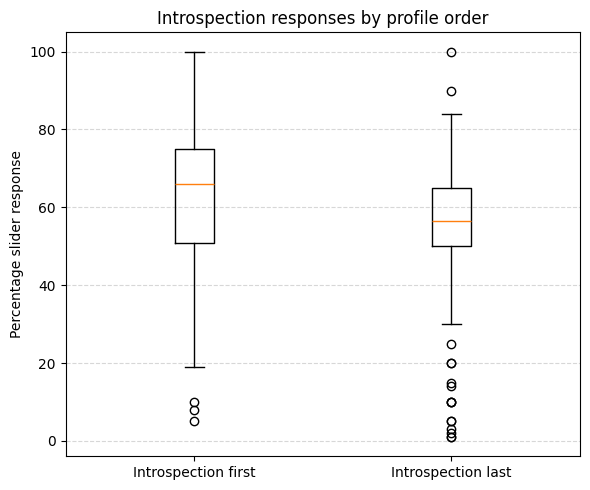

In [193]:
# Keep only introspection trials
df_intro = df[
    (df["task_type"] == "introspection") &
    (df["intro_position"].isin(["first", "last"]))
].copy()

groups = [
    df_intro[df_intro["intro_position"] == "first"]["response"].dropna(),
    df_intro[df_intro["intro_position"] == "last"]["response"].dropna(),
]

plt.figure(figsize=(6, 5))
plt.boxplot(
    groups,
    tick_labels=["Introspection first", "Introspection last"],
    showfliers=True,
)

plt.ylabel("Percentage slider response")
plt.title("Introspection responses by profile order")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

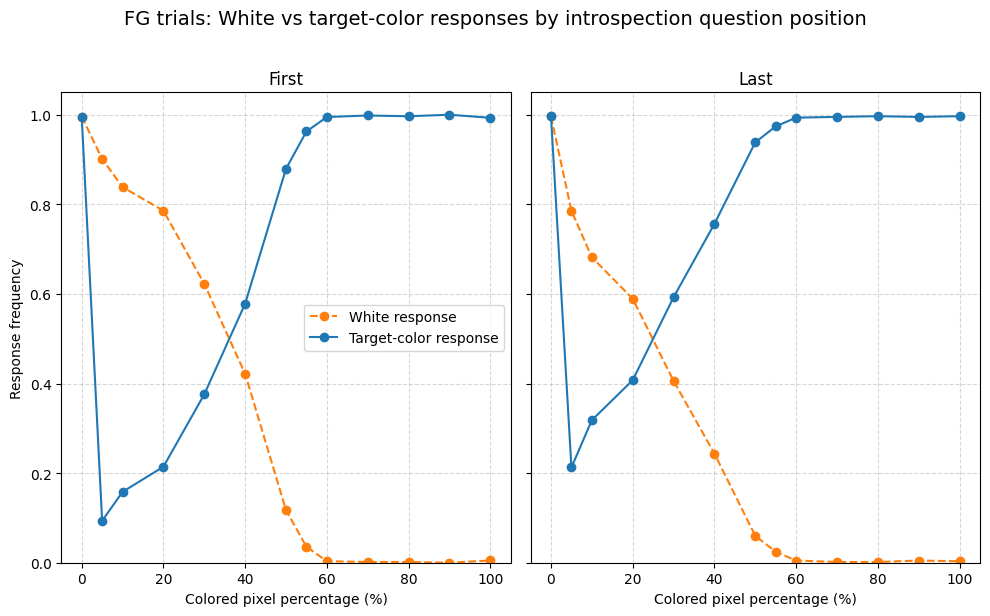

In [194]:
df_fg = df_complete[
    (df_complete["variant_region"] == "FG") &
    (df_complete["intro_position"].isin(["first", "last"]))
].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "FG trials: White vs target-color responses by introspection question position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

for ax, pos in zip(axes, intro_positions):
    df_sub = df_fg[df_fg["intro_position"] == pos]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_target=("is_target", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o--",
        label="White response",
        color="#ff7f0e",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_target"],
        "o-",
        label="Target-color response",
        color="#1f77b4",
    )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


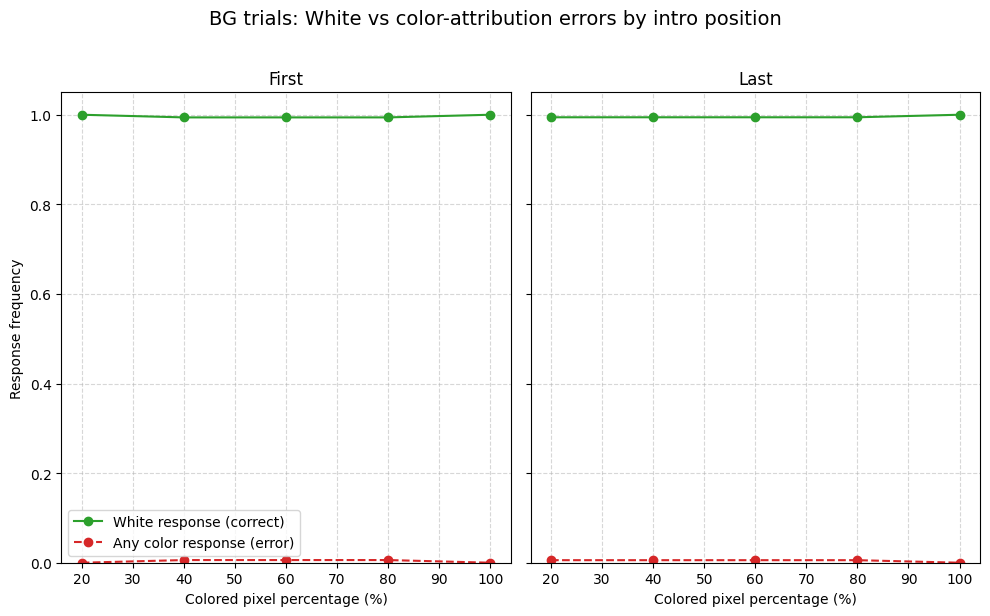

In [195]:
df_bg = df_complete[
    (df_complete["variant_region"] == "BG") &
    (df_complete["intro_position"].isin(["first", "last"]))
].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "BG trials: White vs color-attribution errors by intro position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

for ax, pos in zip(axes, intro_positions):
    df_sub = df_bg[df_bg["intro_position"] == pos]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_colored=("is_colored", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o-",
        label="White response (correct)",
        color="#2ca02c",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_colored"],
        "o--",
        label="Any color response (error)",
        color="#d62728",
    )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()

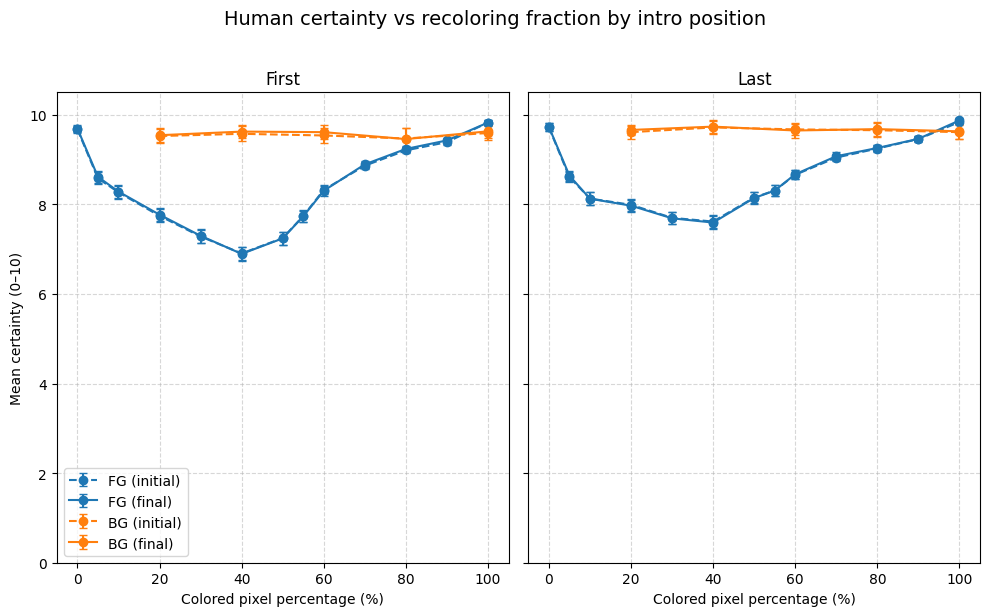

In [196]:
df_cert = df_complete[
    df_complete["intro_position"].isin(["first", "last"])
].copy()

df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(
        ["intro_position", "variant_region", "percent_colored"]
    )
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

cert_summary = pd.concat(
    [
        summarize_certainty(df_cert, "initial_certainty"),
        summarize_certainty(df_cert, "final_certainty"),
    ],
    ignore_index=True
)

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "Human certainty vs recoloring fraction by intro position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

colors = {"FG": "#1f77b4", "BG": "#ff7f0e"}
linestyles = {"initial_certainty": "--", "final_certainty": "-"}

labels = {
    ("FG", "initial_certainty"): "FG (initial)",
    ("FG", "final_certainty"): "FG (final)",
    ("BG", "initial_certainty"): "BG (initial)",
    ("BG", "final_certainty"): "BG (final)",
}

for ax, pos in zip(axes, intro_positions):
    for region in ["FG", "BG"]:
        for cert_type in ["initial_certainty", "final_certainty"]:
            sub = cert_summary[
                (cert_summary["intro_position"] == pos) &
                (cert_summary["variant_region"] == region) &
                (cert_summary["certainty_type"] == cert_type)
            ]

            if sub.empty:
                continue

            ax.errorbar(
                sub["percent_colored"],
                sub["mean"],
                yerr=sub["ci"],
                fmt="o",
                linestyle=linestyles[cert_type],
                color=colors[region],
                capsize=3,
                label=labels[(region, cert_type)],
            )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Mean certainty (0–10)")
axes[0].set_ylim(0, 10.5)
axes[0].legend()

plt.tight_layout()
plt.show()


## Split by stimulus type

In [197]:
df_complete.stimulus_type.value_counts()

stimulus_type
correct_prior    7568
shape            7568
counterfact      2064
Name: count, dtype: int64

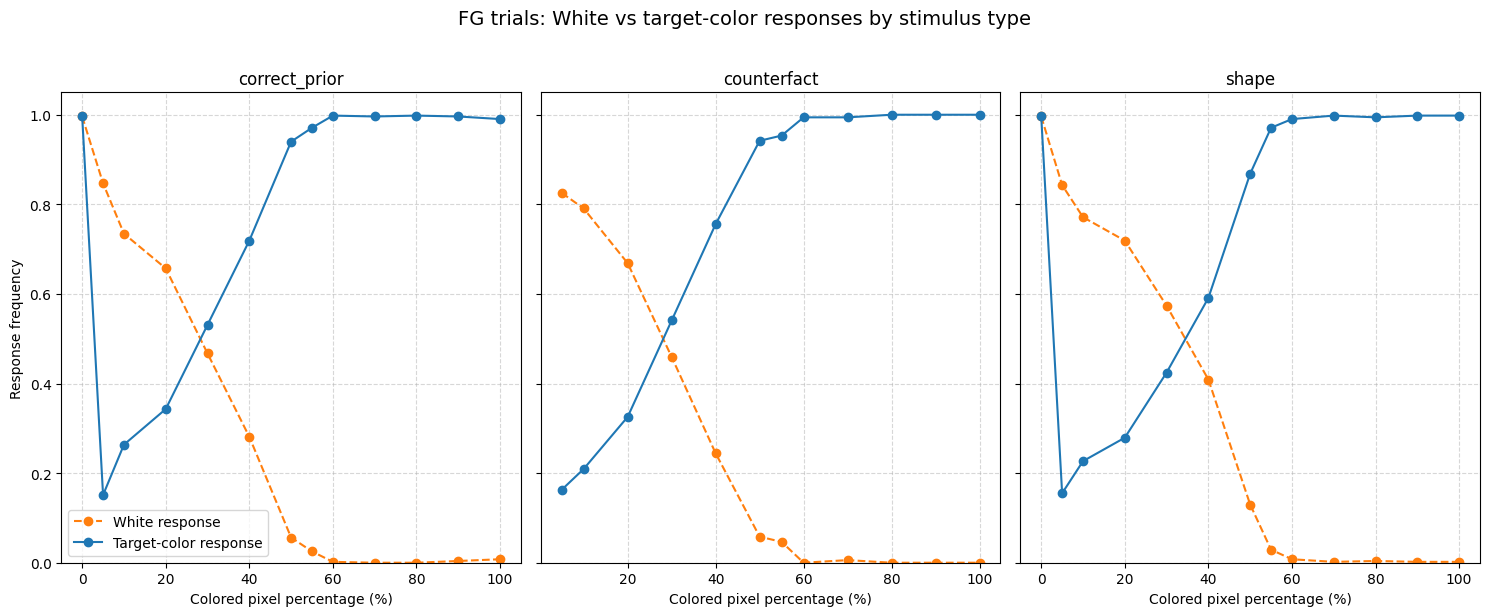

In [198]:
df_fg = df_complete[df_complete["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

stimulus_types = sorted(df_fg["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "FG trials: White vs target-color responses by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

for ax, stim in zip(axes, stimulus_types):
    df_sub = df_fg[df_fg["stimulus_type"] == stim]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_target=("is_target", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o--",
        label="White response",
        color="#ff7f0e",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_target"],
        "o-",
        label="Target-color response",
        color="#1f77b4",
    )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


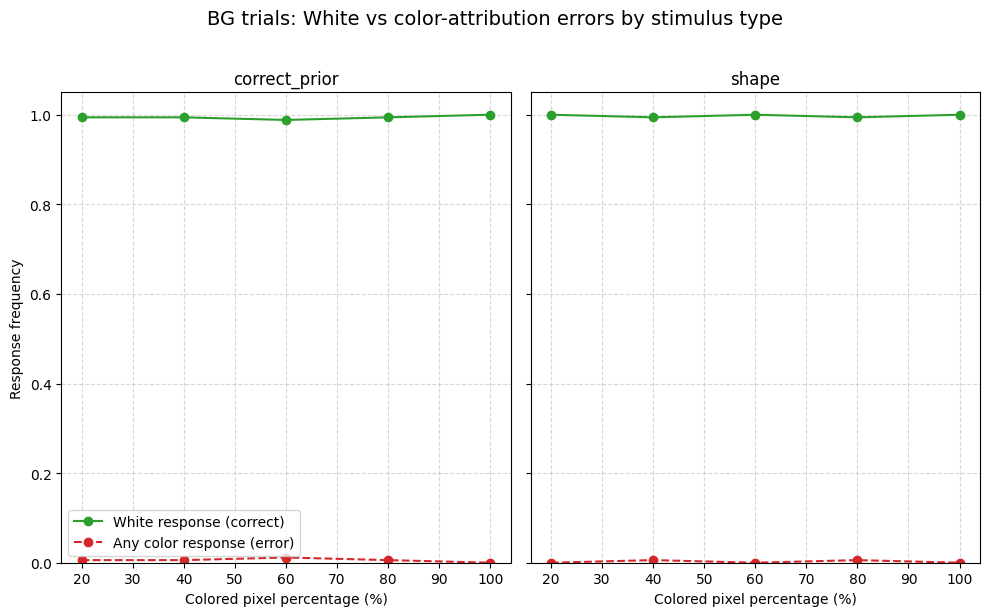

In [199]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

stimulus_types = sorted(df_bg["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "BG trials: White vs color-attribution errors by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

for ax, stim in zip(axes, stimulus_types):
    df_sub = df_bg[df_bg["stimulus_type"] == stim]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_colored=("is_colored", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o-",
        label="White response (correct)",
        color="#2ca02c",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_colored"],
        "o--",
        label="Any color response (error)",
        color="#d62728",
    )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


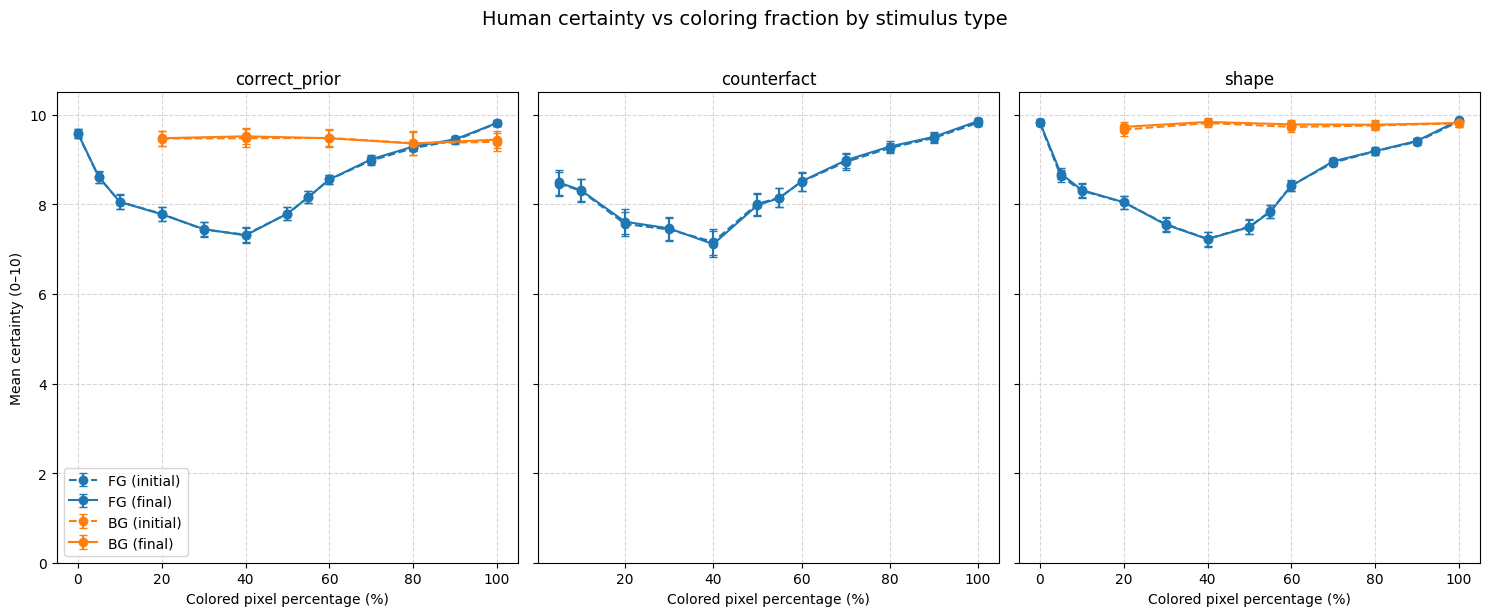

In [200]:
df_cert = df_complete.copy()

# Make sure certainty is numeric
df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

# If final is missing, fall back to initial
df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(
        ["stimulus_type", "variant_region", "percent_colored"]
    )
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

final_summary = summarize_certainty(df_cert, "final_certainty")
initial_summary = summarize_certainty(df_cert, "initial_certainty")

cert_summary = pd.concat(
    [initial_summary, final_summary],
    ignore_index=True
)

stimulus_types = sorted(df_cert["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "Human certainty vs coloring fraction by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

linestyles = {
    "initial_certainty": "--",
    "final_certainty": "-",
}

labels = {
    ("FG", "initial_certainty"): "FG (initial)",
    ("FG", "final_certainty"): "FG (final)",
    ("BG", "initial_certainty"): "BG (initial)",
    ("BG", "final_certainty"): "BG (final)",
}

for ax, stim in zip(axes, stimulus_types):
    for region in ["FG", "BG"]:
        for cert_type in ["initial_certainty", "final_certainty"]:
            sub = cert_summary[
                (cert_summary["stimulus_type"] == stim) &
                (cert_summary["variant_region"] == region) &
                (cert_summary["certainty_type"] == cert_type)
            ]

            if sub.empty:
                continue

            ax.errorbar(
                sub["percent_colored"],
                sub["mean"],
                yerr=sub["ci"],
                fmt="o",
                linestyle=linestyles[cert_type],
                color=colors[region],
                capsize=3,
                label=labels[(region, cert_type)],
            )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Mean certainty (0–10)")
axes[0].set_ylim(0, 10.5)
axes[0].legend()

plt.tight_layout()
plt.show()